# **Proyek Analisis Sentimen Aplikasi "Qara'a - Belajar Ngaji Quran"**

### BAGIAN 0: SETUP DAN IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
import os
import requests
from io import StringIO
import csv

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Sastrawi (Stemming Bahasa Indonesia)
%pip install sastrawi -q
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory # Alternatif stopword remover

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB # Baik untuk teks & TF-IDF
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# WordCloud
from wordcloud import WordCloud

# Mengatur seed untuk reproduktifitas
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Opsi Pandas
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 200)

print("Semua library berhasil diimport.")
print(f"Versi TensorFlow: {tf.__version__}")

Note: you may need to restart the kernel to use updated packages.
Semua library berhasil diimport.
Versi TensorFlow: 2.16.1


### BAGIAN 1: MEMUAT DATASET

In [2]:
print("--- BAGIAN 1: MEMUAT DATASET ---")
# Pastikan file qaraa_reviews_scraped.csv ada di folder dataset_scraped/
data_path = 'dataset_scraped/qaraa_reviews_scraped.csv'

try:
    df_raw = pd.read_csv(data_path)
    print(f"Dataset berhasil dimuat: {data_path}")
    print(f"Jumlah baris awal: {len(df_raw)}")
    print(f"Jumlah kolom awal: {len(df_raw.columns)}")
    print("Informasi dataset awal:")
    df_raw.info()
    print("\nContoh data awal:")
    print(df_raw.head())
except FileNotFoundError:
    print(f"ERROR: File dataset tidak ditemukan di {data_path}")
    print("Pastikan Anda sudah menjalankan notebook scraping (1_scraping_reviews.ipynb) dan file CSV sudah ada.")
    df_raw = pd.DataFrame() # Buat dataframe kosong agar notebook bisa jalan sebagian

# Hanya gunakan kolom yang relevan, terutama 'content' untuk teks ulasan dan 'score' untuk pelabelan awal jika ada
if not df_raw.empty:
    df = df_raw[['content', 'score']].copy() # 'score' mungkin digunakan untuk validasi lexicon atau pelabelan awal
    print("\nDataset setelah memilih kolom 'content' dan 'score':")
    print(df.head())
else:
    df = pd.DataFrame({'content': [], 'score': []})

--- BAGIAN 1: MEMUAT DATASET ---
Dataset berhasil dimuat: dataset_scraped/qaraa_reviews_scraped.csv
Jumlah baris awal: 11366
Jumlah kolom awal: 11
Informasi dataset awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11366 entries, 0 to 11365
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              11366 non-null  object
 1   userName              11366 non-null  object
 2   userImage             11366 non-null  object
 3   content               11366 non-null  object
 4   score                 11366 non-null  int64 
 5   thumbsUpCount         11366 non-null  int64 
 6   reviewCreatedVersion  9504 non-null   object
 7   at                    11366 non-null  object
 8   replyContent          8198 non-null   object
 9   repliedAt             8198 non-null   object
 10  appVersion            9504 non-null   object
dtypes: int64(2), object(9)
memory usage: 976.9+ KB

Contoh data awal:

### BAGIAN 2: EKSPLORASI DATA AWAL (EDA) & DATA CLEANING

--- BAGIAN 2: EDA & DATA CLEANING ---

Missing values per kolom:
content    0
score      0
dtype: int64
Jumlah baris setelah menghapus content kosong: 11366
Jumlah ulasan duplikat (berdasarkan 'content'): 2649
Jumlah baris setelah menghapus duplikat: 8717


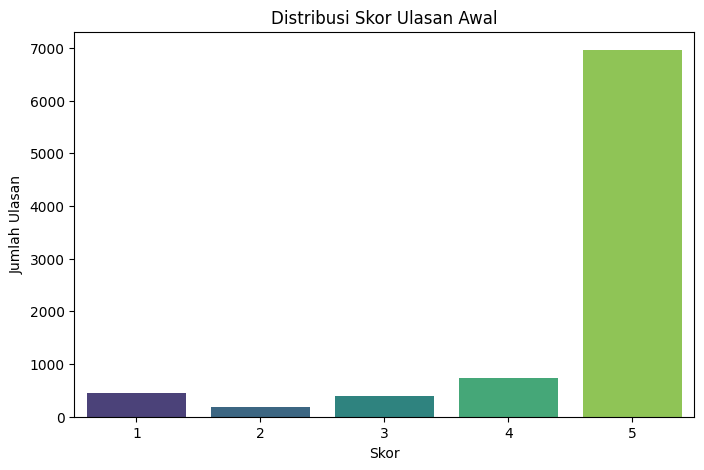

In [3]:
print("--- BAGIAN 2: EDA & DATA CLEANING ---")
# Cek missing values
print("\nMissing values per kolom:")
print(df.isnull().sum())

# Hapus baris dengan 'content' yang kosong (jika ada)
df.dropna(subset=['content'], inplace=True)
df = df[df['content'].str.strip() != ''] # Hapus jika content hanya spasi
print(f"Jumlah baris setelah menghapus content kosong: {len(df)}")

# Cek duplikasi ulasan
print(f"Jumlah ulasan duplikat (berdasarkan 'content'): {df.duplicated(subset=['content']).sum()}")
df.drop_duplicates(subset=['content'], keep='first', inplace=True)
print(f"Jumlah baris setelah menghapus duplikat: {len(df)}")

# Distribusi 'score' (jika akan digunakan)
if 'score' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x='score', data=df, palette='viridis')
    plt.title('Distribusi Skor Ulasan Awal')
    plt.xlabel('Skor')
    plt.ylabel('Jumlah Ulasan')
    plt.show()

### BAGIAN 3: TEXT PREPROCESSING

In [4]:
# 3.1. Fungsi-fungsi Preprocessing
def cleaning_text(text):
    text = str(text).lower() # Case folding awal
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Hapus mention
    text = re.sub(r'#[A-Za-z0-9_]+', ' ', text) # Hapus hashtag
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text) # Hapus URL
    text = re.sub(r'\d+', ' ', text) # Hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation)) # Hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih
    # Hapus karakter non-alfabet
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Kamus slang
slang_dict_local_path = 'lexicons/combined_slang_words.txt'
slang_dict = {}
try:
    with open(slang_dict_local_path, 'r', encoding='utf-8') as f:
        slang_lines = f.readlines() # Baca semua baris
           
    parsed_count = 0
    for line in slang_lines:
        if line.strip(): # Pastikan baris tidak kosong setelah di-strip
            parts = line.split(':', 1) # Split hanya pada colon pertama, jaga-jaga jika value mengandung colon
            if len(parts) == 2:
                key = parts[0].strip().strip('"') # Hapus tanda kutip jika ada di key
                value = parts[1].strip().strip('"') # Hapus tanda kutip jika ada di value
                if key and value: # Pastikan key dan value tidak kosong
                    slang_dict[key] = value
                    parsed_count += 1
    print(f"Kamus slang lokal berhasil dimuat dengan {len(slang_dict)} entri (dari {parsed_count} baris yang diproses).")

except FileNotFoundError:
    print(f"ERROR: File kamus slang lokal tidak ditemukan di {slang_dict_local_path}.")
    print("Menggunakan kamus default kecil sebagai fallback.")
    slang_dict = {
        "yg": "yang", "jg": "juga", "ga": "tidak", "gak": "tidak", "tdk": "tidak",
        "gaada": "tidak ada", "ngga": "tidak", "nggak": "tidak", "kalo": "kalau",
        "sih": "", "deh": "", "dong": "", "nih": "", "spt": "seperti",
        "utk": "untuk", "bgmn": "bagaimana", "sdh": "sudah", "blm": "belum",
        "bgt": "banget", "mantul": "mantap betul", "thx": "terima kasih",
        "apk": "aplikasi", "app": "aplikasi", "min": "admin", "mimin": "admin"
    }
except Exception as e:
    print(f"Terjadi kesalahan saat memuat kamus slang lokal: {e}")
    print("Menggunakan kamus default kecil sebagai fallback.")
    slang_dict = {
        "yg": "yang", "jg": "juga", "ga": "tidak", "gak": "tidak", "tdk": "tidak",
        "gaada": "tidak ada", "ngga": "tidak", "nggak": "tidak", "kalo": "kalau",
        "sih": "", "deh": "", "dong": "", "nih": "", "spt": "seperti",
        "utk": "untuk", "bgmn": "bagaimana", "sdh": "sudah", "blm": "belum",
        "bgt": "banget", "mantul": "mantap betul", "thx": "terima kasih",
        "apk": "aplikasi", "app": "aplikasi", "min": "admin", "mimin": "admin"
    }

def normalize_slang(text):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Stopwords (NLTK Indonesia + tambahan)
stop_words_nltk = list(stopwords.words('indonesian'))
additional_stopwords = [
    'sih', 'deh', 'dong', 'nih', 'kak', 'ka', 'kk', 'gan', 'bro', 'sis', 'nya', 'iya', 'yaa', 'ya', 'yaa',
    'aplikasi', 'aplikasinya', 'app', 'apps', 'qaraa', # kata terkait nama aplikasi
    'saya', 'aku', 'gue', 'gw', 'gua', # kata ganti orang pertama sering muncul tapi kurang informatif untuk sentimen umum
    'admin', 'mimin', 'developer', 'dev', # kata terkait pengembang
    'tolong', 'mohon', 'bantu', # kata permintaan
    'update', 'versi', # kata terkait versi aplikasi
    'download', 'instal', 'install' # kata terkait instalasi
]
stop_words_combined = list(set(stop_words_nltk + additional_stopwords))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words_combined and len(word) > 2] # Hapus kata pendek juga
    return ' '.join(filtered_words)

# Stemming (Sastrawi)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_text(text):
    return stemmer.stem(text)

# 3.2. Menerapkan Preprocessing
if not df.empty:
    print("\nMemulai proses preprocessing teks...")
    start_time = time.time()

    df['text_cleaned'] = df['content'].apply(cleaning_text)
    print("Cleaning selesai.")
    df['text_normalized'] = df['text_cleaned'].apply(normalize_slang)
    print("Normalisasi slang selesai.")
    df['text_no_stopwords'] = df['text_normalized'].apply(remove_stopwords)
    print("Stopword removal selesai.")
    # Stemming
    df_processed = df[df['text_no_stopwords'].str.strip() != ''].copy()
    if not df_processed.empty:
        df_processed['text_stemmed'] = df_processed['text_no_stopwords'].apply(stemming_text)
        print("Stemming selesai.")
        # Kolom final untuk analisis adalah 'text_stemmed'
        df_processed['text_final'] = df_processed['text_stemmed']
    else:
        print("Tidak ada data setelah stopword removal, skipping stemming.")
        df_processed['text_final'] = "" # Atau handle error

    end_time = time.time()
    print(f"Preprocessing selesai dalam {end_time - start_time:.2f} detik.")
    print("\nContoh data setelah preprocessing:")
    print(df_processed[['content', 'text_final']].head())

    # Hapus baris yang text_final nya kosong setelah semua proses
    df_processed.dropna(subset=['text_final'], inplace=True)
    df_processed = df_processed[df_processed['text_final'].str.strip() != '']
    print(f"Jumlah baris setelah preprocessing dan cleaning akhir: {len(df_processed)}")
else:
    print("\nPreprocessing dilewati karena data kosong.")
    df_processed = pd.DataFrame({'content': [], 'text_final': [], 'score': []})

Kamus slang lokal berhasil dimuat dengan 1 entri (dari 1 baris yang diproses).

Memulai proses preprocessing teks...
Cleaning selesai.
Normalisasi slang selesai.
Stopword removal selesai.
Stemming selesai.
Preprocessing selesai dalam 1702.70 detik.

Contoh data setelah preprocessing:
                                                                                                                                                                                                   content  \
0  Tidak bisa d gunakan karena apa yg d pelajari sama yg d aplikasi berbeda dr pelafalan dan pengucapan sangat jauh yg harus nya tebal malah tipis begitu sebaliknya,,, bagi orang yang sudh bersanad s...   
1  sebenarnya mau kasi bintang 5 tapi, aplikasi ini tu kmaren aku cb cm bisa stuck d satu device, kalau kita punya 2 hape dan mau pake qara'a gak bisa lanjutin ngajinya kalo ga d HP yg ada aplikasi q...   
2                                                 bagus bgttt aplikasi nya memudahkan belajar Alq

### BAGIAN 4: PELABELAN SENTIMEN (3 KELAS: POSITIF, NEGATIF, NETRAL)

--- BAGIAN 4: PELABELAN SENTIMEN ---
Lexicon sudah ada di lexicons\lexicon_positive.csv
Lexicon sudah ada di lexicons\lexicon_negative.csv
Lexicon positif dimuat dengan 3609 entri.
Lexicon negatif dimuat dengan 6607 entri.

Pelabelan sentimen selesai.
Distribusi label sentimen:
positive    5028
negative    2258
neutral     1244
Name: sentiment_label, dtype: int64


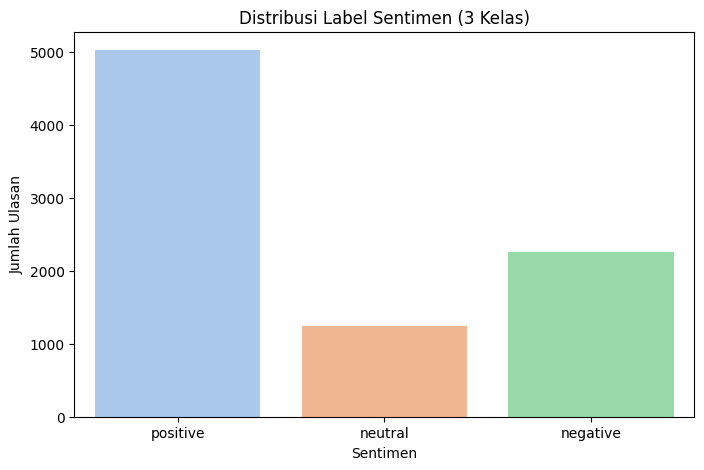


Contoh data dengan label sentimen:
                                                                                                        text_final  \
0  ajar beda lafal ucap tebal tipis orang sudh sanad salah contoh syekh misyari rasyid nilai beliau maasyaa allaah   
1   kasi bintang kmaren stuck device hape pake gak lanjutin ngajinya kalo min upgrade biar akun pake device sosmed   
2                                  bagus bgttt mudah ajar alquran cari lengkappp ajar alquran sampe zikir reminder   
3                                                                                                    alhamdulillah   
4                                                                                                 bantu tahu agama   

  sentiment_label  sentiment_encoded  
0        negative                  0  
1        negative                  0  
2        negative                  0  
3        positive                  2  
4        negative                  0  


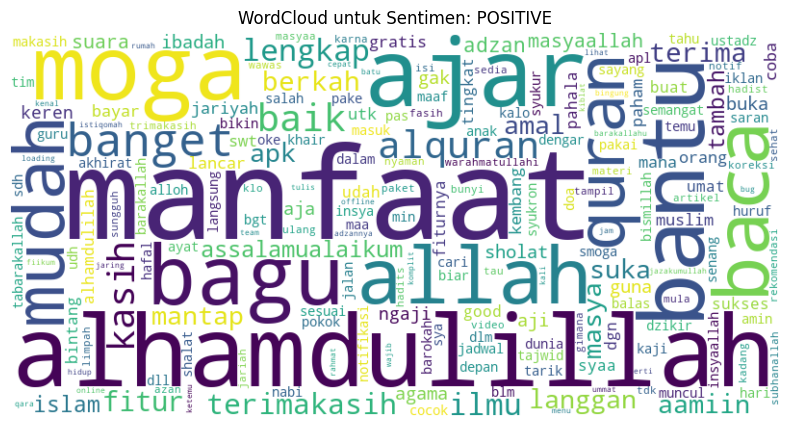

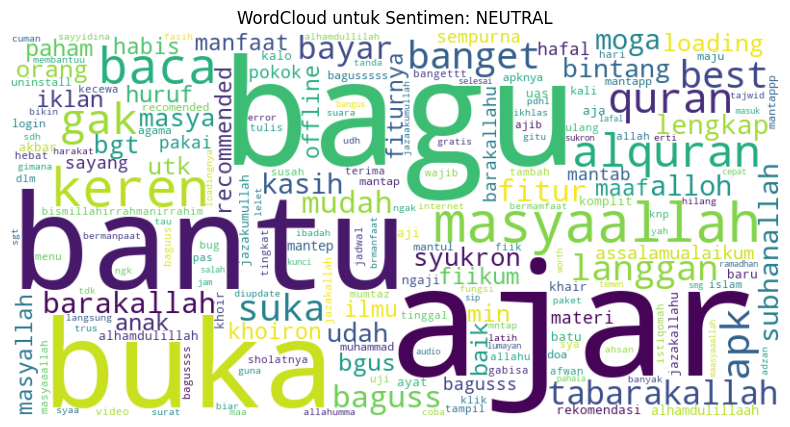

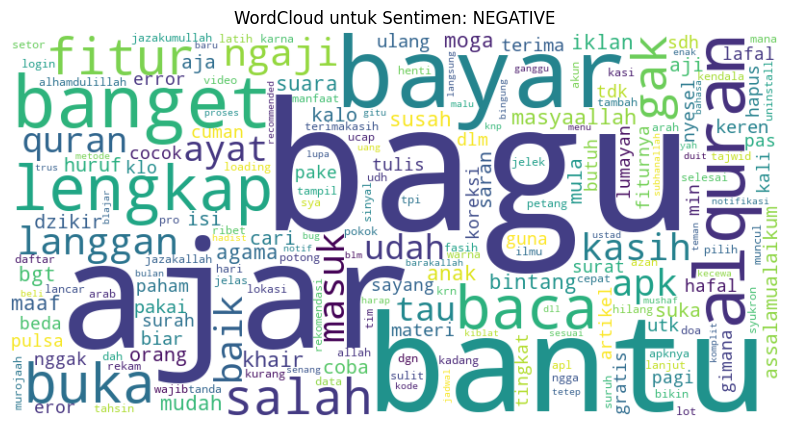

In [5]:
print("--- BAGIAN 4: PELABELAN SENTIMEN ---")
# Kriteria Utama 2 terpenuhi: Melakukan tahapan pelabelan data
# Saran 3 terpenuhi: Dataset memiliki tiga kelas

# Menggunakan lexicon dari contoh
lexicon_pos_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
lexicon_neg_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

# Membuat folder lexicons jika belum ada
lexicon_folder = 'lexicons'
if not os.path.exists(lexicon_folder):
    os.makedirs(lexicon_folder)

lexicon_positive_path = os.path.join(lexicon_folder, 'lexicon_positive.csv')
lexicon_negative_path = os.path.join(lexicon_folder, 'lexicon_negative.csv')

def download_lexicon(url, path):
    if not os.path.exists(path):
        try:
            response = requests.get(url)
            response.raise_for_status()
            with open(path, 'w', encoding='utf-8') as f:
                f.write(response.text)
            print(f"Lexicon berhasil diunduh dan disimpan di {path}")
            return True
        except requests.exceptions.RequestException as e:
            print(f"Gagal mengunduh lexicon dari {url}: {e}")
            return False
    else:
        print(f"Lexicon sudah ada di {path}")
        return True

# Unduh lexicon jika belum ada
download_lexicon(lexicon_pos_url, lexicon_positive_path)
download_lexicon(lexicon_neg_url, lexicon_negative_path)

# Memuat lexicon ke dictionary
lexicon_positive = {}
lexicon_negative = {}

try:
    with open(lexicon_positive_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            if len(row) == 2: lexicon_positive[row[0]] = int(row[1])
    print(f"Lexicon positif dimuat dengan {len(lexicon_positive)} entri.")
except FileNotFoundError:
    print(f"ERROR: File lexicon positif tidak ditemukan di {lexicon_positive_path}")

try:
    with open(lexicon_negative_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            if len(row) == 2: lexicon_negative[row[0]] = int(row[1])
    print(f"Lexicon negatif dimuat dengan {len(lexicon_negative)} entri.")
except FileNotFoundError:
    print(f"ERROR: File lexicon negatif tidak ditemukan di {lexicon_negative_path}")

def sentiment_lexicon_labeling(text):
    score = 0
    words = word_tokenize(str(text).lower()) # Tokenize lagi teks final (stemmed)
    for word in words:
        score += lexicon_positive.get(word, 0)
        score += lexicon_negative.get(word, 0) # Skor negatif sudah negatif

    # Aturan untuk 3 kelas
    if score > 0: 
        return 'positive'
    elif score < 0: 
        return 'negative'
    else: # Skor 0 atau di antara threshold
        return 'neutral'

if not df_processed.empty and 'text_final' in df_processed.columns:
    df_processed['sentiment_label'] = df_processed['text_final'].apply(sentiment_lexicon_labeling)
    print("\nPelabelan sentimen selesai.")
    print("Distribusi label sentimen:")
    print(df_processed['sentiment_label'].value_counts())

    plt.figure(figsize=(8, 5))
    sns.countplot(x='sentiment_label', data=df_processed, palette='pastel', order=['positive', 'neutral', 'negative'])
    plt.title('Distribusi Label Sentimen (3 Kelas)')
    plt.xlabel('Sentimen')
    plt.ylabel('Jumlah Ulasan')
    plt.show()

    # Encoding label menjadi numerik
    label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
    df_processed['sentiment_encoded'] = df_processed['sentiment_label'].map(label_mapping)
    print("\nContoh data dengan label sentimen:")
    print(df_processed[['text_final', 'sentiment_label', 'sentiment_encoded']].head())
else:
    print("\nPelabelan dilewati karena data hasil preprocessing kosong.")


# Visualisasi WordCloud per sentimen
if not df_processed.empty and 'sentiment_label' in df_processed.columns:
    for sentiment_type in ['positive', 'neutral', 'negative']:
        subset = df_processed[df_processed['sentiment_label'] == sentiment_type]
        if not subset.empty:
            text_concat = " ".join(review for review in subset.text_final)
            if text_concat.strip(): # Hanya buat wordcloud jika ada teks
                wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text_concat)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title(f'WordCloud untuk Sentimen: {sentiment_type.upper()}')
                plt.show()
            else:
                print(f"Tidak ada teks untuk WordCloud sentimen {sentiment_type}")
        else:
            print(f"Tidak ada data untuk sentimen {sentiment_type}")

### BAGIAN 5: PEMBAGIAN DATA & EKSTRAKSI FITUR

In [6]:
# Kriteria Utama 2 terpenuhi: Melakukan tahapan ekstraksi fitur

if not df_processed.empty and 'text_final' in df_processed.columns and 'sentiment_encoded' in df_processed.columns:
    print("--- BAGIAN 5: PEMBAGIAN DATA & EKSTRAKSI FITUR ---")
    X = df_processed['text_final']
    y = df_processed['sentiment_encoded']

    # Pembagian data awal (akan divariasikan di skema)
    X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y) # stratify penting untuk data imbalance
    print(f"Ukuran X_train_main: {X_train_main.shape}")
    print(f"Ukuran X_test_main: {X_test_main.shape}")
    print(f"Ukuran y_train_main: {y_train_main.shape}")
    print(f"Ukuran y_test_main: {y_test_main.shape}")
    print("\nDistribusi kelas pada y_train_main:")
    print(y_train_main.value_counts(normalize=True))
    print("\nDistribusi kelas pada y_test_main:")
    print(y_test_main.value_counts(normalize=True))

    # Ekstraksi Fitur: TF-IDF (untuk model ML Klasik)
    # Parameter TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, ngram_range=(1,2)) # ngram (1,2) untuk unigram & bigram

    # Ekstraksi Fitur: Keras Tokenizer (untuk model Deep Learning)
    # Parameter untuk Deep Learning
    MAX_VOCAB_SIZE = 20000 # Jumlah kata unik maks dalam vocabulary
    MAX_SEQUENCE_LENGTH = 200 # Panjang sekuens maks per ulasan (padding/truncating)
    EMBEDDING_DIM = 100 # Dimensi embedding vector

    # Menyiapkan Keras Tokenizer
    keras_tokenizer = KerasTokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<oov>") # <oov> untuk out-of-vocabulary words
    # Fit tokenizer hanya pada data training utama untuk mencegah data leakage
    keras_tokenizer.fit_on_texts(X_train_main)
    word_index = keras_tokenizer.word_index
    print(f"\nFound {len(word_index)} unique tokens in Keras Tokenizer.")

else:
    print("\nPembagian data dan ekstraksi fitur dilewati karena data tidak lengkap.")

# Fungsi bantuan untuk evaluasi model
def evaluate_model(model_name, y_true_train, y_pred_train, y_true_test, y_pred_test):
    train_acc = accuracy_score(y_true_train, y_pred_train)
    test_acc = accuracy_score(y_true_test, y_pred_test)
    print(f"--- {model_name} ---")
    print(f"Akurasi Training: {train_acc*100:.2f}%")
    print(f"Akurasi Testing: {test_acc*100:.2f}%")
    print("\nLaporan Klasifikasi (Test Set):")
    print(classification_report(y_true_test, y_pred_test, target_names=['negative', 'neutral', 'positive'], zero_division=0))
    
    cm = confusion_matrix(y_true_test, y_pred_test)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'Confusion Matrix - {model_name} (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return train_acc, test_acc

# Dictionary untuk menyimpan hasil akurasi semua skema
training_scheme_results = {}

--- BAGIAN 5: PEMBAGIAN DATA & EKSTRAKSI FITUR ---
Ukuran X_train_main: (6824,)
Ukuran X_test_main: (1706,)
Ukuran y_train_main: (6824,)
Ukuran y_test_main: (1706,)

Distribusi kelas pada y_train_main:
2    0.589390
0    0.264801
1    0.145809
Name: sentiment_encoded, dtype: float64

Distribusi kelas pada y_test_main:
2    0.589683
0    0.264361
1    0.145955
Name: sentiment_encoded, dtype: float64

Found 5926 unique tokens in Keras Tokenizer.


### BAGIAN 6: PELATIHAN MODEL (3 SKEMA)

--- BAGIAN 6: PELATIHAN MODEL (3 SKEMA) ---

--- SKEMA 1: Deep Learning (BiLSTM) ---


d:\Anaconda\envs\dsml\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Arsitektur Model BiLSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Memulai pelatihan model BiLSTM...
Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 59s 412ms/step - accuracy: 0.5642 - loss: 1.0055 - val_accuracy: 0.5897 - val_loss: 0.7715 - learning_rate: 5.0000e-04
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 83s 780ms/step - accuracy: 0.7403 - loss: 0.6147 - val_accuracy: 0.8716 - val_loss: 0.3918 - learning_rate: 5.0000e-04
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 43s 404ms/step - accuracy: 0.8982 - loss: 0.3300 - val_accuracy: 0.8898 - val_loss: 0.3209 - learning_rate: 5.0000e-04
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 43s 403ms/step - accuracy: 0.9376 - loss: 0.2206 - val_accuracy: 0.8998 - val_loss: 0.2967 - learning_rate: 5.0000e-04
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 45s 419ms/step - accuracy: 0.9486 - loss: 0.1646 - val_accuracy: 0.9027 - val_loss: 0.2934 - learning_rate: 5.0000e-04
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 48s 444ms/step - accuracy: 0.9602 - loss: 0.1210 - val_accuracy: 0.9080 - val_loss: 0.3228 - learning_rate: 5.0000e-04
Epoch 7/25


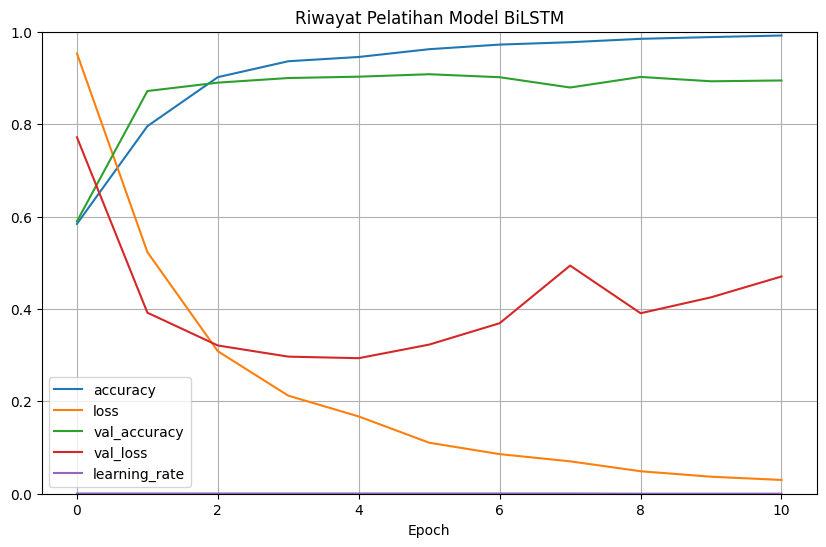

214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step
--- Skema 1: BiLSTM (Embedding Keras, Split 80/20) ---
Akurasi Training: 97.76%
Akurasi Testing: 90.80%

Laporan Klasifikasi (Test Set):
              precision    recall  f1-score   support

    negative       0.93      0.86      0.89       451
     neutral       0.85      0.71      0.78       249
    positive       0.91      0.98      0.94      1006

    accuracy                           0.91      1706
   macro avg       0.90      0.85      0.87      1706
weighted avg       0.91      0.91      0.91      1706



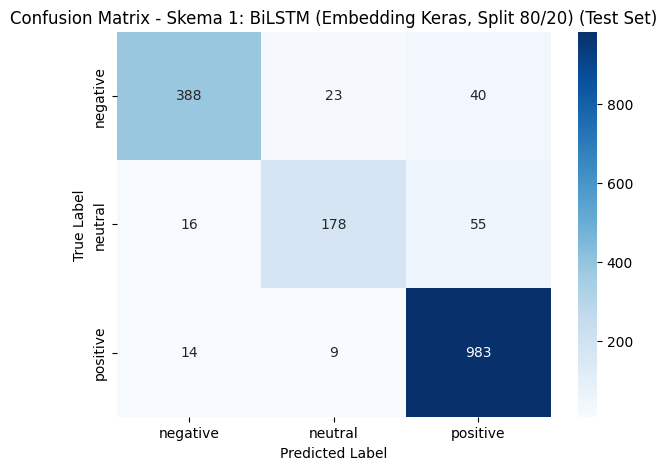

Skema 1: BiLSTM (Embedding Keras, Split 80/20) memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).

--- SKEMA 2: Logistic Regression dengan TF-IDF ---
Dimensi X_train_tfidf_s2: (6824, 1491)

Memulai pelatihan model Logistic Regression...
--- Skema 2: Logistic Regression (TF-IDF, Split 80/20) ---
Akurasi Training: 92.48%
Akurasi Testing: 89.98%

Laporan Klasifikasi (Test Set):
              precision    recall  f1-score   support

    negative       0.89      0.83      0.86       451
     neutral       0.86      0.76      0.80       249
    positive       0.91      0.97      0.94      1006

    accuracy                           0.90      1706
   macro avg       0.89      0.85      0.87      1706
weighted avg       0.90      0.90      0.90      1706



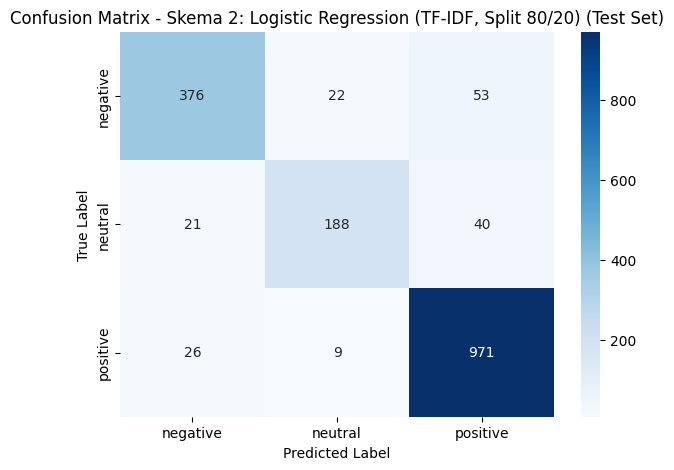

Skema 2: Logistic Regression (TF-IDF, Split 80/20) memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).

--- SKEMA 3: SVM dengan TF-IDF dan Pembagian Data Berbeda ---
Dimensi X_train_tfidf_s3: (5971, 1314)

Memulai pelatihan model SVM...
--- Skema 3: SVM (TF-IDF, Split 70/30) ---
Akurasi Training: 94.09%
Akurasi Testing: 89.72%

Laporan Klasifikasi (Test Set):
              precision    recall  f1-score   support

    negative       0.87      0.84      0.86       677
     neutral       0.78      0.79      0.79       373
    positive       0.94      0.95      0.94      1509

    accuracy                           0.90      2559
   macro avg       0.86      0.86      0.86      2559
weighted avg       0.90      0.90      0.90      2559



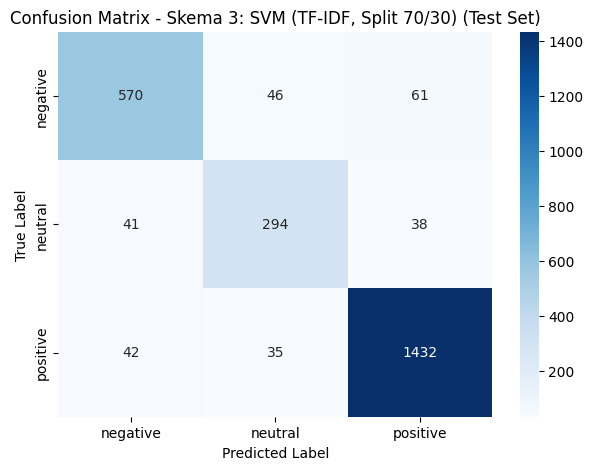

Skema 3: SVM (TF-IDF, Split 70/30) memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).


In [7]:
# Kriteria Utama 3 terpenuhi: Menggunakan algoritma pelatihan machine learning
# Saran 1 terpenuhi: Menggunakan algoritma deep learning (di Skema 1)
# Saran 5 terpenuhi: Melakukan 3 percobaan skema pelatihan yang berbeda

print("--- BAGIAN 6: PELATIHAN MODEL (3 SKEMA) ---")

if not df_processed.empty and 'X_train_main' in locals(): # Cek apakah data siap

    # --------------------------------------------------------------------------
    # SKEMA 1: Deep Learning (BiLSTM) - Target Akurasi Train & Test > 92% (Saran 2)
    # Ekstraksi Fitur: Keras Embedding Layer
    # Pembagian Data: 80% Train / 20% Test (dari X_train_main, y_train_main)
    # --------------------------------------------------------------------------
    print("\n--- SKEMA 1: Deep Learning (BiLSTM) ---")
    scheme_name_1 = "Skema 1: BiLSTM (Embedding Keras, Split 80/20)"

    # Konversi teks ke sekuens angka
    X_train_seq_s1 = keras_tokenizer.texts_to_sequences(X_train_main)
    X_test_seq_s1 = keras_tokenizer.texts_to_sequences(X_test_main)

    # Padding sekuens
    X_train_pad_s1 = pad_sequences(X_train_seq_s1, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    X_test_pad_s1 = pad_sequences(X_test_seq_s1, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    # One-hot encode labels untuk Keras (karena 3 kelas)
    y_train_cat_s1 = to_categorical(y_train_main, num_classes=3)
    y_test_cat_s1 = to_categorical(y_test_main, num_classes=3)

    # Membangun model BiLSTM
    model_bilstm = Sequential([
        Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax') # 3 kelas output, softmax untuk probabilitas
    ])

    model_bilstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # Coba learning rate berbeda
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
    print("\nArsitektur Model BiLSTM:")
    model_bilstm.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1) # Patience bisa ditingkatkan
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

    print("\nMemulai pelatihan model BiLSTM...")
    history_bilstm = model_bilstm.fit(
        X_train_pad_s1, y_train_cat_s1,
        epochs=25,
        batch_size=64,
        validation_data=(X_test_pad_s1, y_test_cat_s1),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Plot history pelatihan
    pd.DataFrame(history_bilstm.history).plot(figsize=(10,6))
    plt.gca().set_ylim(0,1) # Set y-axis from 0 to 1
    plt.title("Riwayat Pelatihan Model BiLSTM")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.show()

    # Evaluasi Model BiLSTM
    y_pred_train_proba_s1 = model_bilstm.predict(X_train_pad_s1)
    y_pred_train_s1 = np.argmax(y_pred_train_proba_s1, axis=1)
    y_pred_test_proba_s1 = model_bilstm.predict(X_test_pad_s1)
    y_pred_test_s1 = np.argmax(y_pred_test_proba_s1, axis=1)

    train_acc_s1, test_acc_s1 = evaluate_model(scheme_name_1, y_train_main, y_pred_train_s1, y_test_main, y_pred_test_s1)
    training_scheme_results[scheme_name_1] = {'train_acc': train_acc_s1, 'test_acc': test_acc_s1}

    if train_acc_s1 > 0.92 and test_acc_s1 > 0.92:
        print(f"SELAMAT! {scheme_name_1} memenuhi target Saran 2 (Akurasi Train & Test > 92%).")
    elif test_acc_s1 >= 0.85:
        print(f"{scheme_name_1} memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).")
    else:
        print(f"PERHATIAN! {scheme_name_1} TIDAK memenuhi Kriteria Utama 4. Perlu optimasi model lebih lanjut.")


    # --------------------------------------------------------------------------
    # SKEMA 2: Machine Learning (Logistic Regression) - Target Akurasi Test > 85%
    # Ekstraksi Fitur: TF-IDF
    # Pembagian Data: 80% Train / 20% Test (dari X_train_main, y_train_main)
    # --------------------------------------------------------------------------
    print("\n--- SKEMA 2: Logistic Regression dengan TF-IDF ---")
    scheme_name_2 = "Skema 2: Logistic Regression (TF-IDF, Split 80/20)"

    # Fit dan transform TF-IDF
    X_train_tfidf_s2 = tfidf_vectorizer.fit_transform(X_train_main)
    X_test_tfidf_s2 = tfidf_vectorizer.transform(X_test_main)
    print(f"Dimensi X_train_tfidf_s2: {X_train_tfidf_s2.shape}")

    # Model Logistic Regression
    logreg_model = LogisticRegression(solver='liblinear', C=1.0, random_state=seed, multi_class='ovr', max_iter=1000)

    print("\nMemulai pelatihan model Logistic Regression...")
    logreg_model.fit(X_train_tfidf_s2, y_train_main)

    # Evaluasi Model Logistic Regression
    y_pred_train_s2 = logreg_model.predict(X_train_tfidf_s2)
    y_pred_test_s2 = logreg_model.predict(X_test_tfidf_s2)

    train_acc_s2, test_acc_s2 = evaluate_model(scheme_name_2, y_train_main, y_pred_train_s2, y_test_main, y_pred_test_s2)
    training_scheme_results[scheme_name_2] = {'train_acc': train_acc_s2, 'test_acc': test_acc_s2}

    if test_acc_s2 >= 0.85:
        print(f"{scheme_name_2} memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).")
    else:
        print(f"PERHATIAN! {scheme_name_2} TIDAK memenuhi Kriteria Utama 4. Perlu optimasi model lebih lanjut.")

    # --------------------------------------------------------------------------
    # SKEMA 3: Machine Learning (SVM) - Target Akurasi Test > 85%
    # Ekstraksi Fitur: TF-IDF (bisa sama dengan Skema 2 atau divariasikan parameternya)
    # Pembagian Data: 70% Train / 30% Test (BERBEDA dari skema sebelumnya)
    # --------------------------------------------------------------------------
    print("\n--- SKEMA 3: SVM dengan TF-IDF dan Pembagian Data Berbeda ---")
    scheme_name_3 = "Skema 3: SVM (TF-IDF, Split 70/30)"

    # Pembagian data baru untuk skema ini (70/30)
    X_train_s3, X_test_s3, y_train_s3, y_test_s3 = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

    # Fit dan transform TF-IDF (bisa menggunakan tfidf_vectorizer yang sama atau baru)
    tfidf_vectorizer_s3 = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, ngram_range=(1,2))
    X_train_tfidf_s3 = tfidf_vectorizer_s3.fit_transform(X_train_s3)
    X_test_tfidf_s3 = tfidf_vectorizer_s3.transform(X_test_s3)
    print(f"Dimensi X_train_tfidf_s3: {X_train_tfidf_s3.shape}")

    # Model SVM
    svm_model = SVC(kernel='linear', C=1.0, random_state=seed, probability=True)

    print("\nMemulai pelatihan model SVM...")
    svm_model.fit(X_train_tfidf_s3, y_train_s3)

    # Evaluasi Model SVM
    y_pred_train_s3 = svm_model.predict(X_train_tfidf_s3)
    y_pred_test_s3 = svm_model.predict(X_test_tfidf_s3)

    train_acc_s3, test_acc_s3 = evaluate_model(scheme_name_3, y_train_s3, y_pred_train_s3, y_test_s3, y_pred_test_s3)
    training_scheme_results[scheme_name_3] = {'train_acc': train_acc_s3, 'test_acc': test_acc_s3}

    if test_acc_s3 >= 0.85:
        print(f"{scheme_name_3} memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).")
    else:
        print(f"PERHATIAN! {scheme_name_3} TIDAK memenuhi Kriteria Utama 4. Perlu optimasi model lebih lanjut.")

else:
    print("\nPelatihan model dilewati karena data tidak siap.")

### BAGIAN 7: PERBANDINGAN HASIL SKEMA PELATIHAN

In [8]:
print("--- BAGIAN 7: PERBANDINGAN HASIL SKEMA PELATIHAN ---")
if training_scheme_results:
    results_df = pd.DataFrame.from_dict(training_scheme_results, orient='index')
    results_df = results_df.sort_values(by='test_acc', ascending=False)
    print(results_df)

    # Cek pemenuhan Saran 5 (aturan akurasi)
    num_schemes_above_85_test = sum(1 for res in training_scheme_results.values() if res['test_acc'] >= 0.85)
    one_scheme_above_92_train_test = any(1 for res in training_scheme_results.values() if res['train_acc'] > 0.92 and res['test_acc'] > 0.92)

    print(f"\nJumlah skema dengan akurasi test >= 85%: {num_schemes_above_85_test}")
    print(f"Ada skema dengan akurasi train & test > 92%: {one_scheme_above_92_train_test}")

    if num_schemes_above_85_test >= 3:
        print("Saran 5 (3 skema pelatihan) terpenuhi dari sisi jumlah skema dengan akurasi test >= 85%.")
        if one_scheme_above_92_train_test:
             print("Saran 2 (Akurasi >92%) juga terpenuhi untuk setidaknya satu skema.")
        else:
            print("Saran 2 (Akurasi >92%) TIDAK terpenuhi. Pastikan minimal satu skema mencapai target ini.")
    else:
        print("PERHATIAN: Saran 5 (3 skema pelatihan) belum sepenuhnya terpenuhi dari sisi target akurasi untuk semua skema.")
        print("Pastikan setidaknya 3 skema memiliki akurasi test >= 85%.")
        print("Jika menargetkan Saran 2, pastikan satu skema >92% (train & test) dan sisanya >=85% (test).")

else:
    print("Tidak ada hasil skema pelatihan untuk dibandingkan.")

--- BAGIAN 7: PERBANDINGAN HASIL SKEMA PELATIHAN ---
                                                    train_acc  test_acc
Skema 1: BiLSTM (Embedding Keras, Split 80/20)       0.977579  0.907972
Skema 2: Logistic Regression (TF-IDF, Split 80/20)   0.924824  0.899766
Skema 3: SVM (TF-IDF, Split 70/30)                   0.940881  0.897225

Jumlah skema dengan akurasi test >= 85%: 3
Ada skema dengan akurasi train & test > 92%: False
Saran 5 (3 skema pelatihan) terpenuhi dari sisi jumlah skema dengan akurasi test >= 85%.
Saran 2 (Akurasi >92%) TIDAK terpenuhi. Pastikan minimal satu skema mencapai target ini.


### BAGIAN 8: INFERENCE DENGAN MODEL TERBAIK

In [10]:
# Saran 6 terpenuhi: Melakukan inference yang menghasilkan output kelas kategorikal

print("--- BAGIAN 8: INFERENCE DENGAN MODEL TERBAIK ---")

def predict_sentiment_new_text(text, model_dl, keras_tokenizer_inf, label_map_inv):
    # Preprocessing teks baru (sama seperti saat training)
    cleaned = cleaning_text(text)
    normalized = normalize_slang(cleaned)
    no_stopwords = remove_stopwords(normalized)
    stemmed = stemming_text(no_stopwords)
    final_text = stemmed
    print(f"Teks setelah preprocessing: '{final_text}'")

    if not final_text.strip():
        return "Tidak ada teks untuk diprediksi setelah preprocessing.", None

    # Konversi ke sekuens dan padding (untuk model DL)
    sequence = keras_tokenizer_inf.texts_to_sequences([final_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    # Prediksi
    prediction_proba = model_dl.predict(padded_sequence, verbose=0)
    predicted_class_index = np.argmax(prediction_proba, axis=1)[0]
    predicted_sentiment_label = label_map_inv.get(predicted_class_index, "Tidak Diketahui")
    
    return predicted_sentiment_label, prediction_proba[0]


if 'model_bilstm' in locals() and 'keras_tokenizer' in locals(): # Cek model dan tokenizer ada
    # Buat inverse mapping untuk label
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}

    contoh_ulasan_1 = "Aplikasinya bagus banget, sangat membantu belajar Quran jadi mudah dan menyenangkan!"
    contoh_ulasan_2 = "Banyak iklan yang mengganggu, jadi malas pakainya."
    contoh_ulasan_3 = "Lumayan sih, tapi fiturnya standar aja."
    contoh_ulasan_4 = "Error terus pas dibuka, tolong perbaiki dong developernya."
    contoh_ulasan_5 = "Alhamdulillah, anak saya jadi semangat ngaji pakai aplikasi ini."

    list_ulasan_test = [contoh_ulasan_1, contoh_ulasan_2, contoh_ulasan_3, contoh_ulasan_4, contoh_ulasan_5]

    print("\nMelakukan inference pada beberapa contoh ulasan baru:")
    for i, ulasan in enumerate(list_ulasan_test):
        print(f"\nUlasan {i+1}: \"{ulasan}\"")
        pred_label, pred_proba = predict_sentiment_new_text(ulasan, model_bilstm, keras_tokenizer, inverse_label_mapping)
        print(f"Prediksi Sentimen: {pred_label.upper()}")
        if pred_proba is not None:
            print(f"Probabilitas: Positif={pred_proba[inverse_label_mapping.get('positive',2)]:.2f}, Neutral={pred_proba[inverse_label_mapping.get('neutral',1)]:.2f}, Negatif={pred_proba[inverse_label_mapping.get('negative',0)]:.2f}")
else:
    print("Inference dilewati karena model BiLSTM atau Keras Tokenizer tidak tersedia.")

--- BAGIAN 8: INFERENCE DENGAN MODEL TERBAIK ---

Melakukan inference pada beberapa contoh ulasan baru:

Ulasan 1: "Aplikasinya bagus banget, sangat membantu belajar Quran jadi mudah dan menyenangkan!"
Teks setelah preprocessing: 'bagus banget bantu ajar quran mudah senang'
Prediksi Sentimen: POSITIVE
Probabilitas: Positif=1.00, Neutral=0.00, Negatif=0.00

Ulasan 2: "Banyak iklan yang mengganggu, jadi malas pakainya."
Teks setelah preprocessing: 'iklan ganggu malas pakai'
Prediksi Sentimen: NEGATIVE
Probabilitas: Positif=0.00, Neutral=0.00, Negatif=1.00

Ulasan 3: "Lumayan sih, tapi fiturnya standar aja."
Teks setelah preprocessing: 'lumayan fiturnya standar aja'
Prediksi Sentimen: NEGATIVE
Probabilitas: Positif=0.02, Neutral=0.45, Negatif=0.52

Ulasan 4: "Error terus pas dibuka, tolong perbaiki dong developernya."
Teks setelah preprocessing: 'error pas buka baik developer'
Prediksi Sentimen: NEGATIVE
Probabilitas: Positif=0.02, Neutral=0.15, Negatif=0.84

Ulasan 5: "Alhamdulillah, ana

### BAGIAN 9: KESIMPULAN